<a href="https://colab.research.google.com/github/Rodri-Putrino/challenge-ml/blob/develop/engineer-segunda-parte/challenge_meli_ej2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

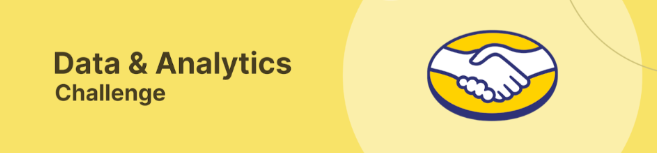

# Ingesta y Limpieza de Datos

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

BASE_URL = "https://api.mercadolibre.com/"
SEARCH_TERMS = ["chromecast", "Google Home", "Apple TV", "Amazon Fire TV"]
MAX_THREADS = 10
MAX_LIMIT = 50

In [2]:
def fetch_items_data(search_term, offset, limit):
    url = f"{BASE_URL}sites/MLA/search?q={search_term}&offset={offset}&limit={limit}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data.get("results", [])
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {search_term}: {e}")
        return []

In [3]:
def fetch_item_details(item_id):
    url = f"{BASE_URL}items/{item_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching details for item {item_id}: {e}")
        return None

In [4]:
def process_search_term(search_term):
    items_data = []
    offset = 0
    while True:
        page_data = fetch_items_data(search_term, offset, MAX_LIMIT)
        if not page_data:
            break
        items_data.extend(page_data)
        offset += MAX_LIMIT

    item_details_list = []
    if items_data:
        with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
            futures = [executor.submit(fetch_item_details, item["id"]) for item in items_data]
            for future in futures:
                item_details = future.result()
                if item_details:
                    item_details["search_term"] = search_term
                    item_details_list.append(item_details)

    return item_details_list

In [5]:
def flatten_df(df):
  df['seller_city'] = df['seller_address'].apply(lambda x: x['city']['name'])
  df['seller_state'] = df['seller_address'].apply(lambda x: x['state']['name'])
  df['seller_country'] = df['seller_address'].apply(lambda x: x['country']['name'])

  return df

In [6]:
item_details_list = []

with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    futures = [executor.submit(process_search_term, term) for term in SEARCH_TERMS]
    for future in futures:
        item_details_list.extend(future.result())

item_details_df = pd.DataFrame(item_details_list)

In [7]:
item_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                785 non-null    object 
 1   site_id                           785 non-null    object 
 2   title                             785 non-null    object 
 3   seller_id                         785 non-null    int64  
 4   category_id                       785 non-null    object 
 5   official_store_id                 2 non-null      float64
 6   price                             785 non-null    float64
 7   base_price                        785 non-null    float64
 8   original_price                    40 non-null     float64
 9   currency_id                       785 non-null    object 
 10  initial_quantity                  785 non-null    int64  
 11  sale_terms                        785 non-null    object 
 12  buying_m

In [8]:
item_details_flatten = flatten_df(item_details_df)

selected_columns = ['id', 'search_term', 'title', 'seller_id', 'seller_city', 'seller_state', 'seller_country', 'price', 'initial_quantity', 'condition', 'status', 'date_created', 'last_updated', 'warranty']
filtered_df = item_details_flatten[selected_columns]

filtered_df.to_csv('results.csv', index=False)

# Análisis exploratorio

In [11]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                785 non-null    object 
 1   search_term       785 non-null    object 
 2   title             785 non-null    object 
 3   seller_id         785 non-null    int64  
 4   seller_city       785 non-null    object 
 5   seller_state      785 non-null    object 
 6   seller_country    785 non-null    object 
 7   price             785 non-null    float64
 8   initial_quantity  785 non-null    int64  
 9   condition         785 non-null    object 
 10  status            785 non-null    object 
 11  date_created      785 non-null    object 
 12  last_updated      785 non-null    object 
 13  warranty          766 non-null    object 
dtypes: float64(1), int64(2), object(11)
memory usage: 86.0+ KB


In [12]:
filtered_df.head()

,id,search_term,title,seller_id,seller_city,seller_state,seller_country,price,initial_quantity,condition,status,date_created,last_updated,warranty
0,MLA1393687066,chromecast,Chromecast Google Tv Hd 8gb 2gb Ram 60 Fps Wif...,126269313,Palermo,Capital Federal,Argentina,73166.31,1588,new,active,2023-04-12T13:10:55.000Z,2024-05-06T21:44:32.589Z,Garantía del vendedor: 6 meses
1,MLA1658635728,chromecast,Google Chromecast 3 Full Hd Media Streaming Negro,69526727,Monserrat,Capital Federal,Argentina,49390.00,453,new,active,2024-02-05T15:36:51.000Z,2024-05-06T21:17:39.236Z,Garantía del vendedor: 12 meses
2,MLA1413602835,chromecast,Chromecast Google Tv Hd 8gb 2gb Ram 60 Fps Wif...,21497735,Flores,Capital Federal,Argentina,71249.05,2599,new,active,2024-03-08T17:02:50.000Z,2024-05-06T21:42:48.678Z,Garantía del vendedor: 30 días
3,MLA1658673372,chromecast,Google Chromecast 3ra Generación Streaming Hdm...,1473286957,San Nicolás,Capital Federal,Argentina,49199.00,480,new,active,2024-02-05T15:07:43.000Z,2024-05-06T21:19:28.600Z,Garantía del vendedor: 12 meses
4,MLA1520563200,chromecast,Chromecast With Google Tv De Voz 4ª Generación...,1473286957,San Nicolás,Capital Federal,Argentina,85399.00,90,new,active,2023-09-27T13:50:47.000Z,2024-05-06T19:08:13.000Z,Garantía del vendedor: 12 meses


In [13]:
print(filtered_df['warranty'].value_counts())

warranty
Sin garantía                       217
Garantía del vendedor: 6 meses     157
Garantía del vendedor: 3 meses     130
Garantía de fábrica: 6 meses        55
Garantía de fábrica: 12 meses       39
Garantía del vendedor: 30 días      39
Garantía del vendedor: 1 meses      24
Garantía de fábrica: 3 meses        23
Garantía del vendedor: 12 meses     19
Garantía de fábrica: 30 días        11
Garantía del vendedor: 90 días       7
Garantía de fábrica: 1 años          5
Garantía de fábrica: 2 meses         4
Garantía del vendedor: 60 días       4
Garantía del vendedor: 24 meses      3
Garantía del vendedor: 1 días        3
Garantía del vendedor: 7 días        3
Garantía de fábrica: 9 meses         2
Garantía de fábrica: 90 días         2
Garantía de fábrica: 1 meses         2
Garantía del vendedor: 1 años        2
Garantía del vendedor: 2 días        2
Garantía del vendedor: 3 días        1
Garantía del vendedor: 100 días      1
Garantía del vendedor: 5 meses       1
Garantía del ven

In [14]:
print(filtered_df['condition'].value_counts())

condition
new     550
used    235
Name: count, dtype: int64


In [16]:
df_group_by_search_term = filtered_df.groupby('search_term')

In [17]:
df_group_by_search_term['seller_city'].describe()

,count,unique,top,freq
search_term,,,,
Amazon Fire TV,124,47,Córdoba,12
Apple TV,99,70,Paternal,5
Google Home,76,35,Paternal,27
chromecast,486,155,Martin Coronado,24


In [19]:
price_stats_by_search_term = df_group_by_search_term['price'].agg(['mean', 'max', 'min']).reset_index()
price_stats_by_search_term.columns = ['search_term', 'precio_promedio', 'precio_max', 'precio_min']
price_stats_by_search_term.head()

,search_term,precio_promedio,precio_max,precio_min
0,Amazon Fire TV,98584.905000,325000.0,50000.00
1,Apple TV,156845.662222,763400.0,16813.56
2,Google Home,125311.263158,1100000.0,3999.00
3,chromecast,90941.980432,584992.0,2500.00


## Profile Report

In [ ]:
!pip install ydata_profiling

In [10]:
from ydata_profiling import ProfileReport

In [20]:
profile = ProfileReport(filtered_df, title="Profiling Report")

In [21]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]